In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D
import os
import cv2
import pickle
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext tensorboard

In [2]:
dataPath = "../../data/OCT/OCT2017/"

In [3]:
labels_available = os.listdir(os.path.join(dataPath, "train"))
print("Total Number of Classes Detected :",len(labels_available))

labels_list = ['NORMAL',"CNV","DME","DRUSEN"]

Total Number of Classes Detected : 4


In [4]:
images=[]
y_trn=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "train", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        images.append(cv2.imread(os.path.join(xPath, y)))
        y_trn.append(labels_list.index(x))
    print(x ,end=" ")

y_train = to_categorical(y_trn,len(labels_list))

NORMAL CNV DME DRUSEN 

In [5]:
x_val=[]
y_val=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "val", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_val.append(cv2.imread(os.path.join(xPath, y)))
        y_val.append(labels_list.index(x))
    print(x ,end=" ")

y_validation = to_categorical(y_val,len(labels_list))

NORMAL CNV DME DRUSEN 

In [6]:
x_tst=[]
y_tst=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "test", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_tst.append(cv2.imread(os.path.join(xPath, y)))
        y_tst.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [7]:
def resizeIm(im, size):
    if im.shape[2] == 1:
        im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    return cv2.resize(im, size)

def resizeIms(x, size):
    return np.array(list(map(lambda im: resizeIm(im, size), x)))

In [8]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction, model):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];
        self.logPath = os.path.join(model, "log.txt")

        if not os.path.isdir(model):
            os.mkdir(model)

        with open(self.logPath,'w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open(self.logPath,'a') as f:
              f.write('End of logging..\n')
    
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

## Load models

In [9]:
# xception base model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
xceptionNetModel = Xception(weights='imagenet')

# opticnet base model
opticNetModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')

# resnet base model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resNetModel = ResNet50(weights='imagenet')

In [13]:
def emptyModelGenerator(model, newWeights=False):
    model = model.lower()
    if model == "resnet":
        x = resNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=resNetModel.input, outputs=predictions)
        size = (224, 224)
    elif model == "xception":
        x = xceptionNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=xceptionNetModel.input, outputs=predictions)
        size = (299, 299)
    elif model == "opticnet":
        newModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')
        size = (224, 224)
    if newWeights:
        newModel = tf.keras.models.clone_model(newModel)
    return newModel, size


def testPredict(model, size, name=None):
    X_test = resizeIms(x_tst, size)
    X_test = np.array(X_test)
    Y_test = np.array(y_tst)
    
    prediction = model.predict(X_test)
    preds = np.argmax(prediction, axis=1)
    acc = sum(preds == Y_test) / len(Y_test)
    print(f'Test acc for {name if name else "model"}: {acc:.6f}')
    

def computeConfussionMatrix(predictions, labels):
    num_labels = len(labels_list)
    cMatrix = np.zeros(shape=(num_labels, num_labels))
    for i in len(predictions):
        p = int(predictions[i])
        t = int(predictions[i])
        cMatrix[t, p] += 1
    print(cMatrix)
    ax = sns.heatmap(cMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion matrix")
    plt.show();
    return cMatrix
    


In [14]:
optim = Adam(learning_rate=0.001)
epochs = 30
batch_size = 50

Labels fraction: [0.01037431 0.00938046 0.01092704 0.01021356]
Training xception for 0.01% of train size (aka 834 images)...


<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 33s 1s/step - loss: 1.3738 - accuracy: 0.3957 - val_loss: 1.3866 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 12s 730ms/step - loss: 1.3267 - accuracy: 0.6684 - val_loss: 1.3870 - val_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - 13s 735ms/step - loss: 1.3029 - accuracy: 0.6766 - val_loss: 1.3875 - val_accuracy: 0.2500
Epoch 4/30
17/17 [==============================] - 13s 740ms/step - loss: 1.2885 - accuracy: 0.6667 - val_loss: 1.3882 - val_accuracy: 0.2500
Epoch 5/30
17/17 [==============================] - 13s 740ms/step - loss: 1.2821 - accuracy: 0.6517 - val_loss: 1.3888 - val_accuracy: 0.2500
Epoch 6/30
17/17 [==============================] - 13s 744ms/step - loss: 1.2606 - accuracy: 0.6919 - val_loss: 1.3896 - val_accuracy: 0.2500
Epoch 7/30
17/17 [==============================] - 13s 747ms/step - loss: 1.2521 - accuracy: 0.6851 - val_loss: 1.3905 - val_accuracy: 0.2500
Epoch 8/30
17/17 [==============================] - 13s 749ms/step - loss: 1.2314 - accuracy: 0.7242 - val_loss: 1.3914 - val_accuracy: 0.2500

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 17s 533ms/step - loss: 1.3704 - accuracy: 0.3325 - val_loss: 1.3886 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 3s 196ms/step - loss: 1.3495 - accuracy: 0.3654 - val_loss: 1.3900 - val_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - 3s 197ms/step - loss: 1.3381 - accuracy: 0.3526 - val_loss: 1.3914 - val_accuracy: 0.2500
Epoch 4/30
17/17 [==============================] - 3s 197ms/step - loss: 1.3265 - accuracy: 0.4018 - val_loss: 1.3929 - val_accuracy: 0.3125
Epoch 5/30
17/17 [==============================] - 3s 197ms/step - loss: 1.3145 - accuracy: 0.6016 - val_loss: 1.3980 - val_accuracy: 0.2500
Epoch 6/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2999 - accuracy: 0.6531 - val_loss: 1.3899 - val_accuracy: 0.3750
Epoch 7/30
17/17 [==============================] - 3s 196ms/step - loss: 1.2984 - accuracy: 0.6325 - val_loss: 1.4015 - val_accuracy: 0.2500
Epoch 8/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2822 - accuracy: 0.6677 - val_loss: 1.3954 - val_accuracy: 0.3125
Epoch 

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 46s 2s/step - loss: 21.8636 - accuracy: 0.2649 - val_loss: 120.5078 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 20s 1s/step - loss: 2.3646 - accuracy: 0.3400 - val_loss: 6.6843 - val_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - 20s 1s/step - loss: 1.8181 - accuracy: 0.3740 - val_loss: 2.0986 - val_accuracy: 0.3438
Epoch 4/30
17/17 [==============================] - 20s 1s/step - loss: 1.4204 - accuracy: 0.4292 - val_loss: 1.6428 - val_accuracy: 0.2500
Epoch 5/30
17/17 [==============================] - 20s 1s/step - loss: 1.3563 - accuracy: 0.4126 - val_loss: 1.6999 - val_accuracy: 0.2500
Epoch 6/30
17/17 [==============================] - 20s 1s/step - loss: 1.2756 - accuracy: 0.4798 - val_loss: 2.3789 - val_accuracy: 0.2188
Epoch 7/30
17/17 [==============================] - 20s 1s/step - loss: 1.4581 - accuracy: 0.4740 - val_loss: 1.8517 - val_accuracy: 0.2500
Epoch 8/30
17/17 [==============================] - 20s 1s/step - loss: 1.2700 - accuracy: 0.5149 - val_loss: 1.8607 - val_accuracy: 0.3125
Epoch 9/30
17/17 [==

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 42s 885ms/step - loss: 1.3491 - accuracy: 0.5894 - val_loss: 1.3875 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 32s 758ms/step - loss: 1.2731 - accuracy: 0.7142 - val_loss: 1.3897 - val_accuracy: 0.2500
Epoch 3/30
42/42 [==============================] - 32s 763ms/step - loss: 1.2400 - accuracy: 0.7007 - val_loss: 1.3927 - val_accuracy: 0.2500
Epoch 4/30
42/42 [==============================] - 32s 764ms/step - loss: 1.2177 - accuracy: 0.6917 - val_loss: 1.3961 - val_accuracy: 0.2500
Epoch 5/30
42/42 [==============================] - 32s 764ms/step - loss: 1.1814 - accuracy: 0.7133 - val_loss: 1.4020 - val_accuracy: 0.2500
Epoch 6/30
42/42 [==============================] - 32s 762ms/step - loss: 1.1511 - accuracy: 0.7351 - val_loss: 1.4393 - val_accuracy: 0.2500
Epoch 7/30
42/42 [==============================] - 32s 765ms/step - loss: 1.1329 - accuracy: 0.7342 - val_loss: 1.4487 - val_accuracy: 0.2500
Epoch 8/30
42/42 [==============================] - 32s 768ms/step - loss: 1.1110 - accuracy: 0.7399 - val_loss: 1.4309 - val_accuracy: 0.2500

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 20s 323ms/step - loss: 1.3560 - accuracy: 0.4093 - val_loss: 1.3937 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 8s 196ms/step - loss: 1.3191 - accuracy: 0.4691 - val_loss: 1.3994 - val_accuracy: 0.2500
Epoch 3/30
42/42 [==============================] - 8s 197ms/step - loss: 1.2898 - accuracy: 0.5155 - val_loss: 1.3927 - val_accuracy: 0.3438
Epoch 4/30
42/42 [==============================] - 8s 197ms/step - loss: 1.2658 - accuracy: 0.5916 - val_loss: 1.4160 - val_accuracy: 0.2500
Epoch 5/30
42/42 [==============================] - 8s 198ms/step - loss: 1.2423 - accuracy: 0.6055 - val_loss: 1.4252 - val_accuracy: 0.2500
Epoch 6/30
42/42 [==============================] - 8s 198ms/step - loss: 1.2020 - accuracy: 0.6778 - val_loss: 1.4075 - val_accuracy: 0.3125
Epoch 7/30
42/42 [==============================] - 8s 199ms/step - loss: 1.1837 - accuracy: 0.6837 - val_loss: 1.4323 - val_accuracy: 0.2500
Epoch 8/30
42/42 [==============================] - 8s 199ms/step - loss: 1.1815 - accuracy: 0.6532 - val_loss: 1.4506 - val_accuracy: 0.2500
Epoch 

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 71s 1s/step - loss: 15.9497 - accuracy: 0.3214 - val_loss: 14.6226 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 49s 1s/step - loss: 1.7274 - accuracy: 0.3978 - val_loss: 1.5236 - val_accuracy: 0.2500
Epoch 3/30
42/42 [==============================] - 49s 1s/step - loss: 1.2565 - accuracy: 0.4589 - val_loss: 1.5250 - val_accuracy: 0.2500
Epoch 4/30
42/42 [==============================] - 49s 1s/step - loss: 1.1711 - accuracy: 0.5167 - val_loss: 1.3371 - val_accuracy: 0.2812
Epoch 5/30
42/42 [==============================] - 49s 1s/step - loss: 0.9605 - accuracy: 0.6245 - val_loss: 1.1937 - val_accuracy: 0.4062
Epoch 6/30
42/42 [==============================] - 49s 1s/step - loss: 0.9006 - accuracy: 0.6738 - val_loss: 0.8796 - val_accuracy: 0.6250
Epoch 7/30
42/42 [==============================] - 49s 1s/step - loss: 0.8255 - accuracy: 0.6930 - val_loss: 1.2351 - val_accuracy: 0.5312
Epoch 8/30
42/42 [==============================] - 49s 1s/step - loss: 0.6742 - accuracy: 0.7451 - val_loss: 0.8863 - val_accuracy: 0.6875
Epoch 9/30
42/42 [==

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 74s 819ms/step - loss: 1.3393 - accuracy: 0.5431 - val_loss: 1.3895 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 64s 765ms/step - loss: 1.2328 - accuracy: 0.7028 - val_loss: 1.4070 - val_accuracy: 0.2500
Epoch 3/30
84/84 [==============================] - 64s 768ms/step - loss: 1.1692 - accuracy: 0.7135 - val_loss: 1.4451 - val_accuracy: 0.2500
Epoch 4/30
84/84 [==============================] - 65s 768ms/step - loss: 1.1169 - accuracy: 0.7225 - val_loss: 1.4103 - val_accuracy: 0.2500
Epoch 5/30
84/84 [==============================] - 64s 766ms/step - loss: 1.0625 - accuracy: 0.7390 - val_loss: 1.3952 - val_accuracy: 0.2500
Epoch 6/30
84/84 [==============================] - 64s 767ms/step - loss: 1.0083 - accuracy: 0.7393 - val_loss: 1.3032 - val_accuracy: 0.5000
Epoch 7/30
84/84 [==============================] - 64s 768ms/step - loss: 0.9901 - accuracy: 0.7484 - val_loss: 1.3108 - val_accuracy: 0.5000
Epoch 8/30
84/84 [==============================] - 65s 769ms/step - loss: 0.9417 - accuracy: 0.8139 - val_loss: 1.2309 - val_accuracy: 0.5938

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 30s 258ms/step - loss: 1.3498 - accuracy: 0.4185 - val_loss: 1.4020 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 17s 197ms/step - loss: 1.2994 - accuracy: 0.4448 - val_loss: 1.4226 - val_accuracy: 0.2500
Epoch 3/30
84/84 [==============================] - 17s 198ms/step - loss: 1.2684 - accuracy: 0.4545 - val_loss: 1.4428 - val_accuracy: 0.2500
Epoch 4/30
84/84 [==============================] - 17s 199ms/step - loss: 1.2610 - accuracy: 0.4434 - val_loss: 1.4602 - val_accuracy: 0.2500
Epoch 5/30
84/84 [==============================] - 17s 199ms/step - loss: 1.2552 - accuracy: 0.4408 - val_loss: 1.4757 - val_accuracy: 0.2500
Epoch 6/30
84/84 [==============================] - 17s 199ms/step - loss: 1.2438 - accuracy: 0.4476 - val_loss: 1.4881 - val_accuracy: 0.2500
Epoch 7/30
84/84 [==============================] - 17s 199ms/step - loss: 1.2463 - accuracy: 0.4405 - val_loss: 1.4971 - val_accuracy: 0.2500
Epoch 8/30
84/84 [==============================] - 17s 199ms/step - loss: 1.2363 - accuracy: 0.4505 - val_loss: 1.5053 - val_accuracy: 0.2500

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 118s 1s/step - loss: 8.3875 - accuracy: 0.3467 - val_loss: 1.9013 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 99s 1s/step - loss: 1.4436 - accuracy: 0.4188 - val_loss: 1.5444 - val_accuracy: 0.3125
Epoch 3/30
84/84 [==============================] - 99s 1s/step - loss: 1.0382 - accuracy: 0.6474 - val_loss: 2.9092 - val_accuracy: 0.2500
Epoch 4/30
84/84 [==============================] - 99s 1s/step - loss: 0.8530 - accuracy: 0.6945 - val_loss: 1.0737 - val_accuracy: 0.4375
Epoch 5/30
84/84 [==============================] - 99s 1s/step - loss: 0.7796 - accuracy: 0.7159 - val_loss: 1.4615 - val_accuracy: 0.4688
Epoch 6/30
84/84 [==============================] - 99s 1s/step - loss: 0.7402 - accuracy: 0.7319 - val_loss: 1.1514 - val_accuracy: 0.5312
Epoch 7/30
84/84 [==============================] - 99s 1s/step - loss: 0.6306 - accuracy: 0.7633 - val_loss: 1.1822 - val_accuracy: 0.4688
Epoch 8/30
84/84 [==============================] - 99s 1s/step - loss: 0.5545 - accuracy: 0.7882 - val_loss: 0.8649 - val_accuracy: 0.5000
Epoch 9/30
84/84 [==

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 108s 816ms/step - loss: 1.3179 - accuracy: 0.5867 - val_loss: 1.3935 - val_accuracy: 0.2812


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 97s 772ms/step - loss: 1.1713 - accuracy: 0.7110 - val_loss: 1.4445 - val_accuracy: 0.2500
Epoch 3/30
126/126 [==============================] - 97s 772ms/step - loss: 1.0658 - accuracy: 0.7448 - val_loss: 1.3423 - val_accuracy: 0.4375
Epoch 4/30
126/126 [==============================] - 97s 768ms/step - loss: 1.0049 - accuracy: 0.7384 - val_loss: 1.2763 - val_accuracy: 0.5000
Epoch 5/30
126/126 [==============================] - 97s 768ms/step - loss: 0.9482 - accuracy: 0.7409 - val_loss: 1.2846 - val_accuracy: 0.5000
Epoch 6/30
126/126 [==============================] - 97s 766ms/step - loss: 0.8880 - accuracy: 0.7720 - val_loss: 1.3163 - val_accuracy: 0.5000
Epoch 7/30
126/126 [==============================] - 97s 769ms/step - loss: 0.8582 - accuracy: 0.7998 - val_loss: 1.3270 - val_accuracy: 0.3438
Epoch 8/30
126/126 [==============================] - 97s 769ms/step - loss: 0.8262 - accuracy: 0.8039 - val_loss: 1.2240 - val_ac

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 36s 234ms/step - loss: 1.3282 - accuracy: 0.5668 - val_loss: 1.4076 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 25s 197ms/step - loss: 1.2107 - accuracy: 0.6832 - val_loss: 1.4522 - val_accuracy: 0.2500
Epoch 3/30
126/126 [==============================] - 25s 197ms/step - loss: 1.1310 - accuracy: 0.7021 - val_loss: 1.4212 - val_accuracy: 0.3125
Epoch 4/30
126/126 [==============================] - 25s 198ms/step - loss: 1.0564 - accuracy: 0.7321 - val_loss: 1.3283 - val_accuracy: 0.5000
Epoch 5/30
126/126 [==============================] - 25s 198ms/step - loss: 1.0109 - accuracy: 0.7268 - val_loss: 1.3431 - val_accuracy: 0.5000
Epoch 6/30
126/126 [==============================] - 25s 198ms/step - loss: 0.9833 - accuracy: 0.7230 - val_loss: 1.2796 - val_accuracy: 0.5000
Epoch 7/30
126/126 [==============================] - 25s 199ms/step - loss: 0.9334 - accuracy: 0.7349 - val_loss: 1.2492 - val_accuracy: 0.5000
Epoch 8/30
126/126 [==============================] - 25s 198ms/step - loss: 0.9178 - accuracy: 0.7326 - val_loss: 1.5182 - val_ac

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 168s 1s/step - loss: 6.9772 - accuracy: 0.3824 - val_loss: 1.7494 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 148s 1s/step - loss: 1.0206 - accuracy: 0.6212 - val_loss: 3.0735 - val_accuracy: 0.2500
Epoch 3/30
126/126 [==============================] - 148s 1s/step - loss: 0.7750 - accuracy: 0.7167 - val_loss: 0.8751 - val_accuracy: 0.6250
Epoch 4/30
126/126 [==============================] - 148s 1s/step - loss: 0.6147 - accuracy: 0.7794 - val_loss: 2.3057 - val_accuracy: 0.3438
Epoch 5/30
126/126 [==============================] - 148s 1s/step - loss: 0.4955 - accuracy: 0.8163 - val_loss: 1.1238 - val_accuracy: 0.6250
Epoch 6/30
126/126 [==============================] - 148s 1s/step - loss: 0.3631 - accuracy: 0.8760 - val_loss: 2.2427 - val_accuracy: 0.3750
Epoch 7/30
126/126 [==============================] - 148s 1s/step - loss: 0.3160 - accuracy: 0.8887 - val_loss: 0.7695 - val_accuracy: 0.6875
Epoch 8/30
126/126 [==============================] - 148s 1s/step - loss: 0.2761 - accuracy: 0.9010 - val_loss: 0.2131 - val_accuracy: 0.9375

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 126s 803ms/step - loss: 1.3092 - accuracy: 0.6260 - val_loss: 1.4015 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 117s 774ms/step - loss: 1.1539 - accuracy: 0.7274 - val_loss: 1.4784 - val_accuracy: 0.2500
Epoch 3/30
151/151 [==============================] - 117s 776ms/step - loss: 1.0632 - accuracy: 0.7312 - val_loss: 1.3317 - val_accuracy: 0.5000
Epoch 4/30
151/151 [==============================] - 117s 777ms/step - loss: 0.9956 - accuracy: 0.7243 - val_loss: 1.3690 - val_accuracy: 0.4062
Epoch 5/30
151/151 [==============================] - 116s 771ms/step - loss: 0.9285 - accuracy: 0.7345 - val_loss: 1.2339 - val_accuracy: 0.5312
Epoch 6/30
151/151 [==============================] - 117s 772ms/step - loss: 0.8851 - accuracy: 0.7676 - val_loss: 1.3495 - val_accuracy: 0.4375
Epoch 7/30
151/151 [==============================] - 116s 771ms/step - loss: 0.8372 - accuracy: 0.7828 - val_loss: 1.0526 - val_accuracy: 0.6875
Epoch 8/30
151/151 [==============================] - 117s 777ms/step - loss: 0.8014 - accuracy: 0.7907 - val_loss: 1.0765 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 42s 229ms/step - loss: 1.3307 - accuracy: 0.4826 - val_loss: 1.4132 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 30s 198ms/step - loss: 1.1901 - accuracy: 0.6876 - val_loss: 1.4769 - val_accuracy: 0.2500
Epoch 3/30
151/151 [==============================] - 30s 198ms/step - loss: 1.0950 - accuracy: 0.7113 - val_loss: 1.3935 - val_accuracy: 0.3750
Epoch 4/30
151/151 [==============================] - 30s 199ms/step - loss: 1.0306 - accuracy: 0.7166 - val_loss: 1.2939 - val_accuracy: 0.4688
Epoch 5/30
151/151 [==============================] - 30s 199ms/step - loss: 0.9802 - accuracy: 0.7281 - val_loss: 1.4434 - val_accuracy: 0.3438
Epoch 6/30
151/151 [==============================] - 30s 199ms/step - loss: 0.9544 - accuracy: 0.7187 - val_loss: 1.3142 - val_accuracy: 0.5000
Epoch 7/30
151/151 [==============================] - 30s 199ms/step - loss: 0.9121 - accuracy: 0.7274 - val_loss: 1.1972 - val_accuracy: 0.4375
Epoch 8/30
151/151 [==============================] - 30s 200ms/step - loss: 0.8832 - accuracy: 0.7284 - val_loss: 1.7642 - val_ac

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 196s 1s/step - loss: 6.5228 - accuracy: 0.3825 - val_loss: 2.9973 - val_accuracy: 0.2812


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 178s 1s/step - loss: 0.8790 - accuracy: 0.6806 - val_loss: 1.8278 - val_accuracy: 0.2812
Epoch 3/30
151/151 [==============================] - 178s 1s/step - loss: 0.6799 - accuracy: 0.7462 - val_loss: 0.9180 - val_accuracy: 0.5625
Epoch 4/30
151/151 [==============================] - 178s 1s/step - loss: 0.5463 - accuracy: 0.8038 - val_loss: 1.1080 - val_accuracy: 0.5938
Epoch 5/30
151/151 [==============================] - 177s 1s/step - loss: 0.4804 - accuracy: 0.8347 - val_loss: 0.5760 - val_accuracy: 0.7500
Epoch 6/30
151/151 [==============================] - 177s 1s/step - loss: 0.3836 - accuracy: 0.8609 - val_loss: 0.4046 - val_accuracy: 0.8438
Epoch 7/30
151/151 [==============================] - 178s 1s/step - loss: 0.3228 - accuracy: 0.8854 - val_loss: 0.4175 - val_accuracy: 0.8750
Epoch 8/30
151/151 [==============================] - 178s 1s/step - loss: 0.2996 - accuracy: 0.8911 - val_loss: 0.2699 - val_accuracy: 0.9062

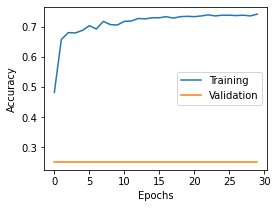

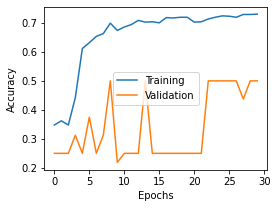

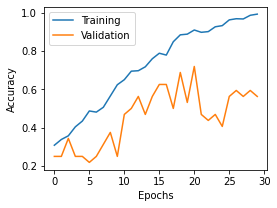

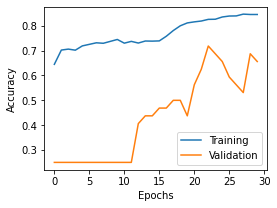

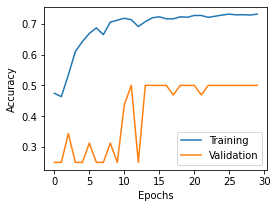

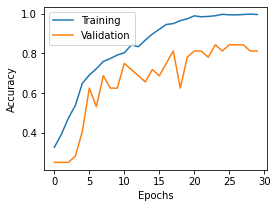

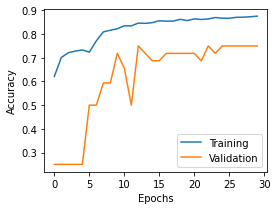

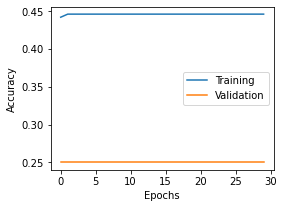

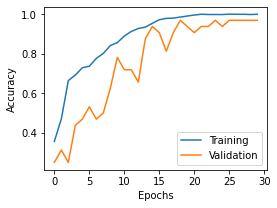

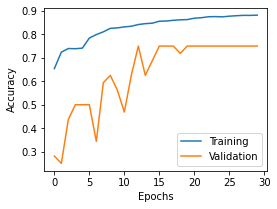

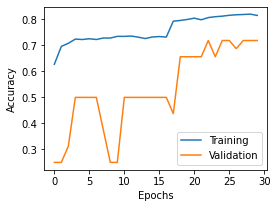

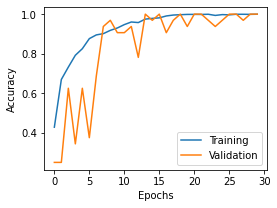

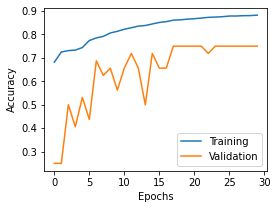

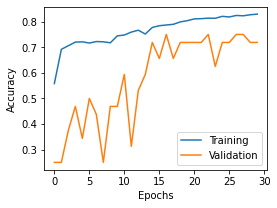

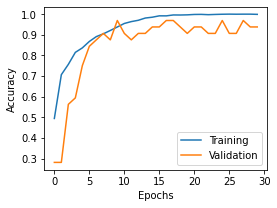

In [15]:
from sklearn.model_selection import train_test_split
import datetime

maxTrain = len(y_train)
#for p in [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]:
for p in [0.01, 0.025, 0.05, 0.075, 0.09]:
    #X_trn, X_tst, y_trn, y_tst
    X_t, _, y_t, _ = train_test_split(images, y_train, test_size=1-p, random_state=123)
    print(f"Labels fraction: {sum(y_t == 1) / sum(y_train == 1)}")
    for net in ["xception", "resnet", "opticnet"]:
        print(f"Training {net} for {p}% of train size (aka {len(X_t)} images)...")
        model, size = emptyModelGenerator(net, True) # new weights
        X_trn = resizeIms(X_t, size)
        X_val = resizeIms(x_val, size)
        log_dir = f"logs/{net}/fit/{p}trainSet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        optim = Adam(learning_rate=0.001)
        model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(X_trn, y_t, epochs=epochs, validation_data = (X_val, y_validation), batch_size=batch_size,
                    shuffle=True, max_queue_size=20,
                    use_multiprocessing=True, workers=5, 
                    callbacks=[CustomCallback(fraction=0.9, model=net), tensorboard_callback])
        model.save(f"../{net}/{net}_{epochs}epochs_{p*maxTrain} images")
        testPredict(model, size, name=net)
        del model
        del X_trn
        del X_val
        print("Done!\n" + '-'*50, end='\n\n')